In [2]:
import numpy as np
import scipy as sp
import torch

import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

import os
import sys

In [3]:
seq2seq_model_path = '/Volumes/Samsung_T5/aoLab/Data/models/pyt/seq2seq/'
hp_sweep_path = os.path.join(seq2seq_model_path,'enc250_dec50_hps_20200523220302959000')
result_file = os.path.join(hp_sweep_path,'hps_results.csv')
result_df = pd.read_csv(result_file)
fig_save_path = './hps_20200528'

In [4]:
# get loop values, plot limits
n_units = np.unique(result_df.n_unit)
l_rate = np.unique(result_df.l_rate)
d_rate = np.unique(result_df.d_rate)
max_loss = np.max((result_df.train_loss_end.max(),result_df.test_loss_end.max()))
min_loss = np.min((result_df.train_loss_end.min(),result_df.test_loss_end.min()))

lr: 0.0001	dr: 0.1
lr: 0.0005	dr: 0.1
lr: 0.001	dr: 0.1
lr: 0.0001	dr: 0.1
lr: 0.0005	dr: 0.1
lr: 0.001	dr: 0.1
lr: 0.0001	dr: 0.1
lr: 0.0005	dr: 0.1
lr: 0.001	dr: 0.1


/Users/mickey/anaconda3/envs/ecog_is2s/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


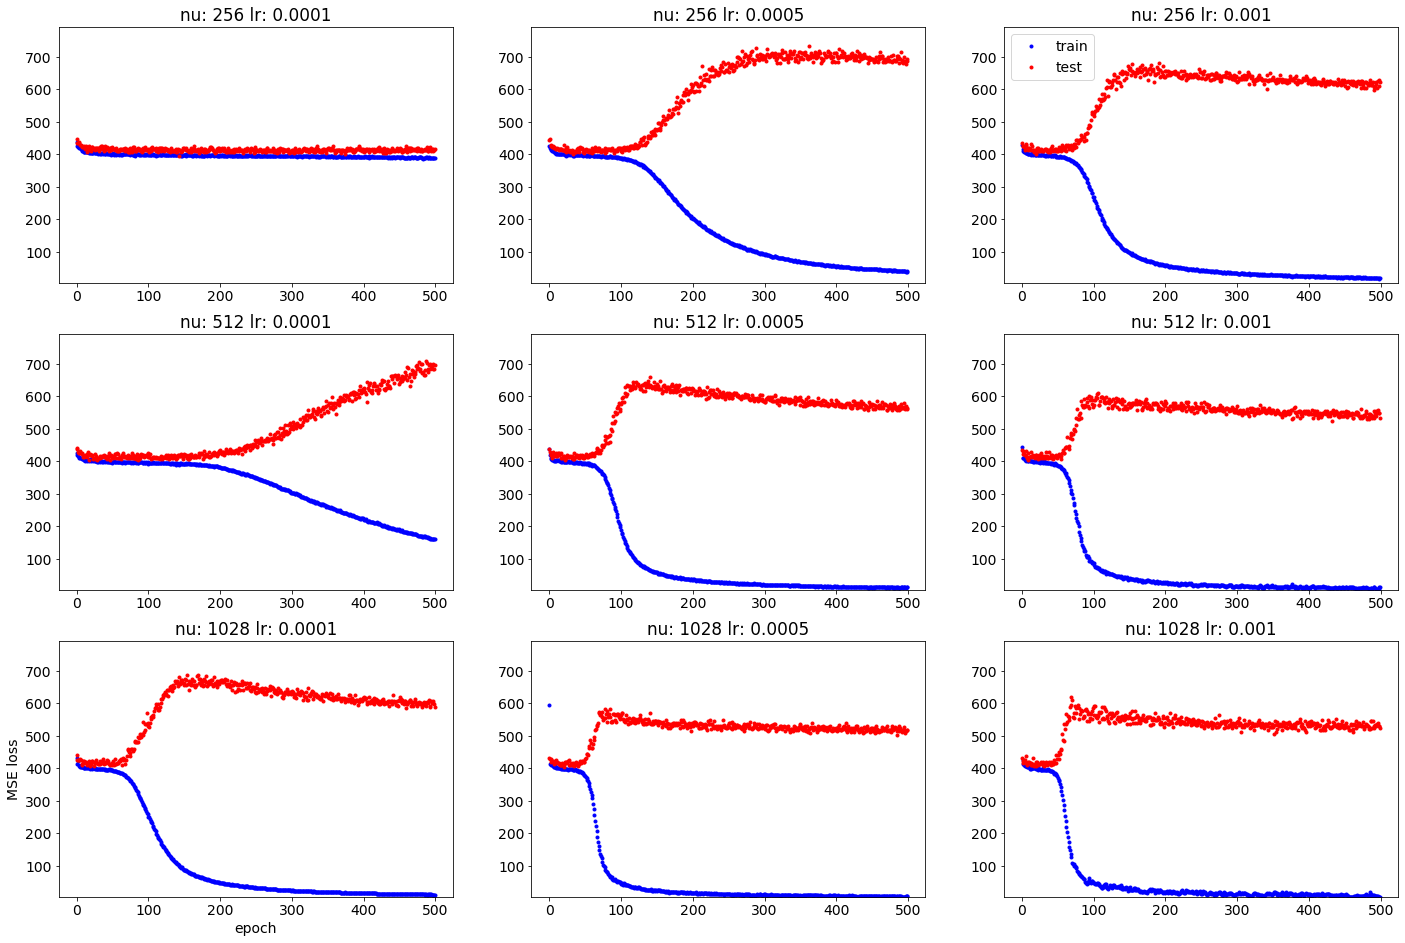

In [5]:
# d_rate isn't doing anything. Fix at d_r = 0.1, plot all n_units + l_r on one figure
f,ax = plt.subplots(len(n_units),len(l_rate),figsize=(24,16))
d_r = d_rate[1]
for n_u_i, n_u in enumerate(n_units):
    for l_r_i, l_r in enumerate(l_rate):
        print('lr: {}\tdr: {}'.format(l_r,d_r))
        model_name = result_df[np.logical_and(result_df.l_rate==l_r,result_df.n_unit==n_u)].iloc[0].id
        lc_data_file = os.path.join(hp_sweep_path,model_name,'training_progress.pt')
        lc_data = torch.load(lc_data_file)
        n_epoch = len(lc_data['train_loss'])
        epochs = np.arange(n_epoch)
        ax[n_u_i,l_r_i].plot(epochs,lc_data['train_loss'],'b.',label='train')
        ax[n_u_i,l_r_i].plot(epochs,lc_data['test_loss'],'r.',label='test')
        ax[n_u_i,l_r_i].set_title('nu: {} lr: {}'.format(n_u,l_r))
        ax[n_u_i,l_r_i].set_ylim([min_loss,max_loss*1.1])
ax[0,len(l_rate)-1].legend(loc=0)
ax[len(n_units)-1,0].set_xlabel('epoch')
ax[len(n_units)-1,0].set_ylabel('MSE loss')
f.show()

we want the 512 unit, 1e-4 learning rate (dropout 0.1) case. That has the most prolonged divergence

In [6]:
l_r = 0.0001
n_u = 512
model_name = result_df[np.logical_and(result_df.l_rate==l_r,result_df.n_unit==n_u)].iloc[0].id
lc_data_file = os.path.join(hp_sweep_path,model_name,'training_progress.pt')
lc_data = torch.load(lc_data_file)
n_epoch = len(lc_data['train_loss'])
epochs = np.arange(n_epoch)

/Users/mickey/anaconda3/envs/ecog_is2s/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


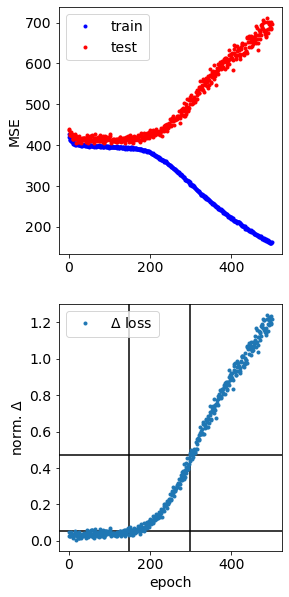

In [7]:
# Percent change from initial loss
loss_change_percent = (lc_data["test_loss"]-lc_data["train_loss"])/lc_data["test_loss"][0]
f_diff,ax = plt.subplots(2,1,figsize=(4,10))
ax[0].plot(epochs,lc_data["train_loss"],'b.',label='train')
ax[0].plot(epochs,lc_data["test_loss"],'r.',label='test')
ax[0].legend(loc=0)
# ax[0].set_title(model_name)
ax[0].set_ylabel('MSE')
ax[1].axvline(149,color='k')
ax[1].axvline(299,color='k')
ax[1].axhline(loss_change_percent[149],color='k')
ax[1].axhline(loss_change_percent[299],color='k')
ax[1].plot(epochs,loss_change_percent,'.',label='$\Delta$ loss')
ax[1].legend(loc=0)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('norm. $\Delta$')
f_diff.show()

#### dissecting the split
Let's look at each step around the break: epochs 150-250

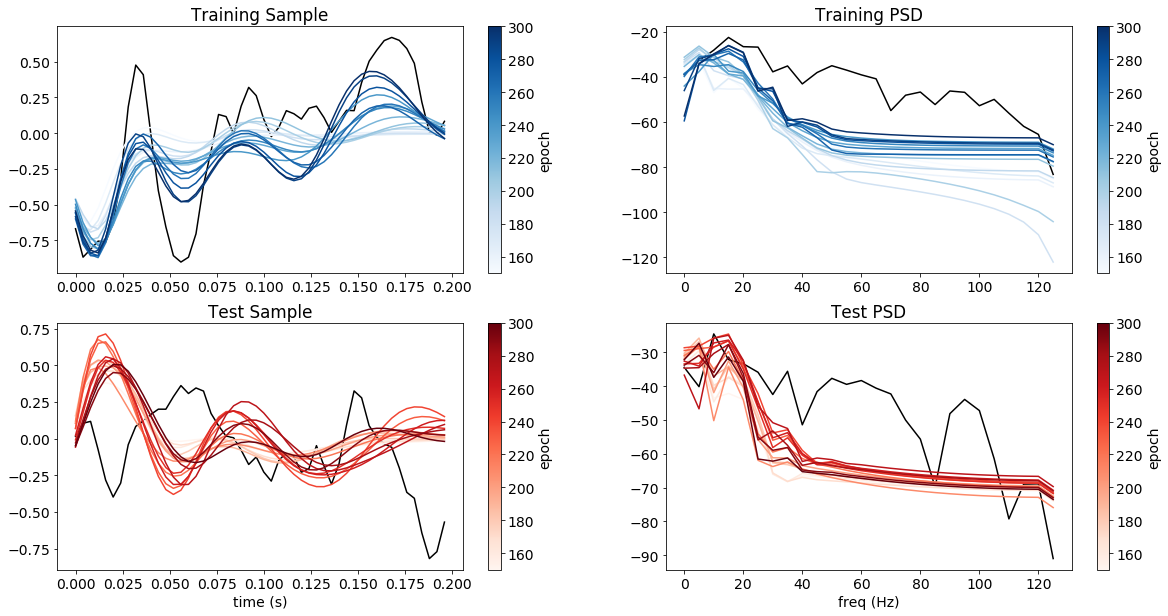

In [8]:
from scipy.signal import periodogram
trace_data_dir = os.path.join(hp_sweep_path,model_name,'example_sequence_figs')
epoch_list = np.arange(150,301,10)
n_plot_epochs = len(epoch_list)
f_prog,ax = plt.subplots(2,2,figsize=(20,10))
ax = ax.T.reshape(-1)
train_cm_f = plt.cm.Blues
test_cm_f = plt.cm.Reds
train_cm = train_cm_f(np.linspace(0,1,n_plot_epochs))
test_cm = test_cm_f(np.linspace(0,1,n_plot_epochs))
p_train = []
p_test = []
for ep_i, ep in enumerate(epoch_list):
    epoch_model_data_file = os.path.join(trace_data_dir,'epoch{}'.format(ep),'model_epoch{}.pt'.format(ep))
    epoch_win0_data_file = os.path.join(trace_data_dir,'epoch{}'.format(ep),'data_tuple_epoch{}_window0.pt'.format(ep))
    epoch_win1_data_file = os.path.join(trace_data_dir,'epoch{}'.format(ep),'data_tuple_epoch{}_window1.pt'.format(ep))
    model_data_dict = torch.load(epoch_model_data_file,map_location=torch.device('cpu')) # necessary when data was generated from GPU
    win0_data_dict = torch.load(epoch_win0_data_file,map_location=torch.device('cpu'))
    win1_data_dict = torch.load(epoch_win1_data_file,map_location=torch.device('cpu'))
    output_time = np.arange(win0_data_dict['trg'].shape[0])/win0_data_dict['srate']
    # compute periodogram
    if ep == epoch_list[0]:
        f, p_trg0_ = periodogram(win0_data_dict['trg'].T,window='hamming',fs=win0_data_dict['srate'],detrend='linear')
        _, p_trg1_ = periodogram(win1_data_dict['trg'].T,window='hamming',fs=win0_data_dict['srate'],detrend='linear')
    _, p_train_ = periodogram(win0_data_dict['out'].T,window='hamming',fs=win0_data_dict['srate'],detrend='linear')
    _, p_test_ = periodogram(win1_data_dict['out'].T,window='hamming',fs=win0_data_dict['srate'],detrend='linear')
    # target trace
    if ep == epoch_list[0]:
        ax[0].plot(output_time,win0_data_dict['trg'],'k',label='trg')
        ax[1].plot(output_time,win1_data_dict['trg'],'k',label='trg')
        ax[2].plot(f,10*np.log10(p_trg0_).T,color='k',label='trg')
        ax[3].plot(f,10*np.log10(p_trg1_).T,color='k',label='trg')
    # estimate trace
    ax[0].plot(output_time,win0_data_dict['out'],color=train_cm[ep_i])
    ax[1].plot(output_time,win1_data_dict['out'],color=test_cm[ep_i])
    ax[2].plot(f,10*np.log10(p_train_).T,color=train_cm[ep_i])
    ax[3].plot(f,10*np.log10(p_test_).T,color=test_cm[ep_i])
# colorbars
iter_train_map = plt.cm.ScalarMappable(cmap=train_cm_f,norm=plt.Normalize(vmin=epoch_list[0], vmax=epoch_list[-1]))
iter_test_map = plt.cm.ScalarMappable(cmap=test_cm_f,norm=plt.Normalize(vmin=epoch_list[0], vmax=epoch_list[-1]))
cb_trace_train = plt.colorbar(iter_train_map,ax=ax[0])
cb_trace_test = plt.colorbar(iter_test_map,ax=ax[1])
cb_psd_train = plt.colorbar(iter_train_map,ax=ax[2])
cb_psd_test = plt.colorbar(iter_test_map,ax=ax[3])
# labels
ax[0].set_title('Training Sample')
ax[1].set_title('Test Sample')
ax[1].set_xlabel('time (s)')
ax[2].set_title('Training PSD')
ax[3].set_title('Test PSD')
ax[3].set_xlabel('freq (Hz)')
cb_trace_train.set_label('epoch')
cb_trace_test.set_label('epoch')
cb_psd_train.set_label('epoch')
cb_psd_test.set_label('epoch')
# save figure
f_prog.savefig('20200601_training_progress.png',dpi=100)

#### visualizing change

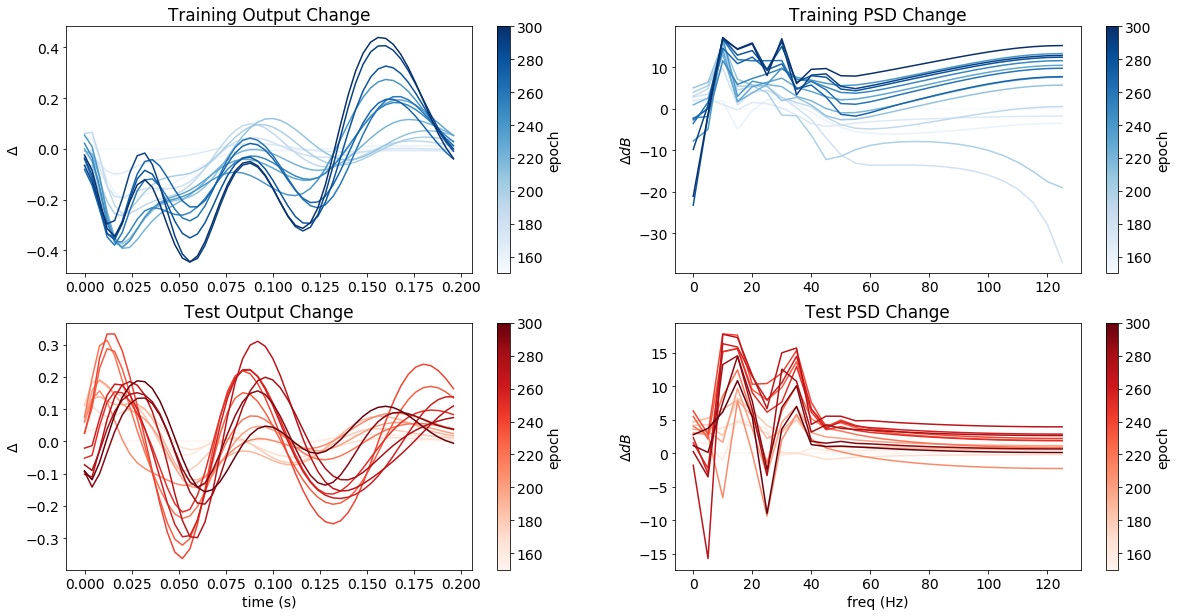

In [9]:
f_diff,ax = plt.subplots(2,2,figsize=(20,10))
ax = ax.T.reshape(-1)
train_cm_f = plt.cm.Blues
test_cm_f = plt.cm.Reds
train_cm = train_cm_f(np.linspace(0,1,n_plot_epochs))
test_cm = test_cm_f(np.linspace(0,1,n_plot_epochs))
p_train = []
p_test = []
for ep_i, ep in enumerate(epoch_list):
    epoch_model_data_file = os.path.join(trace_data_dir,'epoch{}'.format(ep),'model_epoch{}.pt'.format(ep))
    epoch_win0_data_file = os.path.join(trace_data_dir,'epoch{}'.format(ep),'data_tuple_epoch{}_window0.pt'.format(ep))
    epoch_win1_data_file = os.path.join(trace_data_dir,'epoch{}'.format(ep),'data_tuple_epoch{}_window1.pt'.format(ep))
    model_data_dict = torch.load(epoch_model_data_file,map_location=torch.device('cpu')) # necessary when data was generated from GPU
    win0_data_dict = torch.load(epoch_win0_data_file,map_location=torch.device('cpu'))
    win1_data_dict = torch.load(epoch_win1_data_file,map_location=torch.device('cpu'))
    output_time = np.arange(win0_data_dict['trg'].shape[0])/win0_data_dict['srate']
    # compute periodogram
    if ep == epoch_list[0]:
        # initial output traces
        out_train_0 = win0_data_dict['out']
        out_train_1 = win1_data_dict['out']
        f, p_trg0_ = periodogram(win0_data_dict['trg'].T,window='hamming',fs=win0_data_dict['srate'],detrend='linear')
        _, p_trg1_ = periodogram(win1_data_dict['trg'].T,window='hamming',fs=win0_data_dict['srate'],detrend='linear')
        _, p_train_0 = periodogram(win0_data_dict['out'].T,window='hamming',fs=win0_data_dict['srate'],detrend='linear')
        _, p_test_0 = periodogram(win1_data_dict['out'].T,window='hamming',fs=win0_data_dict['srate'],detrend='linear')
    _, p_train_ = periodogram(win0_data_dict['out'].T,window='hamming',fs=win0_data_dict['srate'],detrend='linear')
    _, p_test_ = periodogram(win1_data_dict['out'].T,window='hamming',fs=win0_data_dict['srate'],detrend='linear')
    p_rat_train_ = p_train_/p_train_0
    p_rat_test_ = p_test_/p_test_0
    # target trace
#     if ep == epoch_list[0]:
#         ax[0].plot(output_time,win0_data_dict['trg'],'k',label='trg')
#         ax[1].plot(output_time,win1_data_dict['trg'],'k',label='trg')
#         ax[2].plot(f,10*np.log10(p_trg0_).T,color='k',label='trg')
#         ax[3].plot(f,10*np.log10(p_trg1_).T,color='k',label='trg')
    # estimate trace
    ax[0].plot(output_time,win0_data_dict['out']-out_train_0,color=train_cm[ep_i])
    ax[1].plot(output_time,win1_data_dict['out']-out_train_1,color=test_cm[ep_i])
    ax[2].plot(f,10*np.log10(p_rat_train_).T,color=train_cm[ep_i])
    ax[3].plot(f,10*np.log10(p_rat_test_).T,color=test_cm[ep_i])
# colorbars
iter_train_map = plt.cm.ScalarMappable(cmap=train_cm_f,norm=plt.Normalize(vmin=epoch_list[0], vmax=epoch_list[-1]))
iter_test_map = plt.cm.ScalarMappable(cmap=test_cm_f,norm=plt.Normalize(vmin=epoch_list[0], vmax=epoch_list[-1]))
cb_trace_train = plt.colorbar(iter_train_map,ax=ax[0])
cb_trace_test = plt.colorbar(iter_test_map,ax=ax[1])
cb_psd_train = plt.colorbar(iter_train_map,ax=ax[2])
cb_psd_test = plt.colorbar(iter_test_map,ax=ax[3])
# labels
ax[0].set_ylabel('$\Delta$')
ax[0].set_title('Training Output Change')
ax[1].set_title('Test Output Change')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('$\Delta$')
ax[2].set_ylabel('$\Delta dB$')
ax[2].set_title('Training PSD Change')
ax[3].set_xlabel('freq (Hz)')
ax[3].set_ylabel('$\Delta dB$')
ax[3].set_title('Test PSD Change')
cb_trace_train.set_label('epoch')
cb_trace_test.set_label('epoch')
cb_psd_train.set_label('epoch')
cb_psd_test.set_label('epoch')
# save figure
f_diff.savefig('20200602_training_change.png',dpi=100)

#### parameter evolution

text copied from https://pytorch.org/docs/stable/nn.html#gru


        ~GRU.weight_ih_l[k] – the learnable input-hidden weights of the kth\text{k}^{th}kth layer (W_ir|W_iz|W_in), of shape (3*hidden_size, input_size) for k = 0. Otherwise, the shape is (3*hidden_size, num_directions * hidden_size)

        ~GRU.weight_hh_l[k] – the learnable hidden-hidden weights of the kth\text{k}^{th}kth layer (W_hr|W_hz|W_hn), of shape (3*hidden_size, hidden_size)

        ~GRU.bias_ih_l[k] – the learnable input-hidden bias of the kth\text{k}^{th}kth layer (b_ir|b_iz|b_in), of shape (3*hidden_size)

        ~GRU.bias_hh_l[k] – the learnable hidden-hidden bias of the kth\text{k}^{th}kth layer (b_hr|b_hz|b_hn), of shape (3*hidden_size)

$r_t=σ(W_{ir}x_t+b_{ir}+W_{hr}h_{t−1}+b_{hr})$

$z_t=σ(W_{iz}x_t+b_{iz}+W_{hz}h_{t−1}+b_{hz})$

$n_t=tanh(W_{in}x_t+b_{in}+r_t∗(W_{hn}h_{t−1}+b_{hn}))$

$h_t=(1−z_t)n_t+z_t h_{t−1}$

In [20]:
# note: this will only work for a single layer, as-is.
def split_seq2seq_param_matrices(model_dict):
    ## encoder
    _,n_u_enc = model_dict['encoder.rnn.weight_hh_l0'].shape
    # i -> h
    W_ir_e = model_dict['encoder.rnn.weight_ih_l0'][:n_u_enc,]
    W_iz_e = model_dict['encoder.rnn.weight_ih_l0'][n_u_enc:2*n_u_enc,]
    W_in_e = model_dict['encoder.rnn.weight_ih_l0'][2*n_u_enc:3*n_u_enc,]
    b_ir_e = model_dict['encoder.rnn.bias_ih_l0'][:n_u_enc,]
    b_iz_e = model_dict['encoder.rnn.bias_ih_l0'][n_u_enc:2*n_u_enc,]
    b_in_e = model_dict['encoder.rnn.bias_ih_l0'][2*n_u_enc:3*n_u_enc,]
    # h -> h
    W_hr_e = model_dict['encoder.rnn.weight_hh_l0'][:n_u_enc,]
    W_hz_e = model_dict['encoder.rnn.weight_hh_l0'][n_u_enc:2*n_u_enc,]
    W_hn_e = model_dict['encoder.rnn.weight_hh_l0'][2*n_u_enc:3*n_u_enc,]
    b_hr_e = model_dict['encoder.rnn.bias_hh_l0'][:n_u_enc,]
    b_hz_e = model_dict['encoder.rnn.bias_hh_l0'][n_u_enc:2*n_u_enc,]
    b_hn_e = model_dict['encoder.rnn.bias_hh_l0'][2*n_u_enc:3*n_u_enc,]
    ## decoder
    _,n_u_dec = model_dict['encoder.rnn.weight_hh_l0'].shape
    # i -> h
    W_ir_d = model_dict['decoder.rnn.weight_ih_l0'][:n_u_dec,]
    W_iz_d = model_dict['decoder.rnn.weight_ih_l0'][n_u_dec:2*n_u_dec,]
    W_in_d = model_dict['decoder.rnn.weight_ih_l0'][2*n_u_dec:3*n_u_dec,]
    b_ir_d = model_dict['decoder.rnn.bias_ih_l0'][:n_u_dec,]
    b_iz_d = model_dict['decoder.rnn.bias_ih_l0'][n_u_dec:2*n_u_dec,]
    b_in_d = model_dict['decoder.rnn.bias_ih_l0'][2*n_u_dec:3*n_u_dec,]
    # h -> h
    W_hr_d = model_dict['decoder.rnn.weight_hh_l0'][:n_u_dec,]
    W_hz_d = model_dict['decoder.rnn.weight_hh_l0'][n_u_dec:2*n_u_dec,]
    W_hn_d = model_dict['decoder.rnn.weight_hh_l0'][2*n_u_dec:3*n_u_dec,]
    b_hr_d = model_dict['decoder.rnn.bias_hh_l0'][:n_u_dec,]
    b_hz_d = model_dict['decoder.rnn.bias_hh_l0'][n_u_dec:2*n_u_dec,]
    b_hn_d = model_dict['decoder.rnn.bias_hh_l0'][2*n_u_dec:3*n_u_dec,]
    # fc linear out
    W_fc_d = model_dict['decoder.fc_out.weight']
    b_fc_d = model_dict['decoder.fc_out.bias']
    ## collect into dict
    param_dict = {
        'encoder' : {
            # i -> h
            'Wir' : W_ir_e,
            'Wiz' : W_iz_e,
            'Win' : W_in_e,
            'bir' : b_ir_e,
            'biz' : b_iz_e,
            'bin' : b_in_e,
            # h -> h
            'Whr' : W_hr_e,
            'Whz' : W_hz_e,
            'Whn' : W_hn_e,
            'bhr' : b_hr_e,
            'bhz' : b_hz_e,
            'bhn' : b_hn_e
        },
        'decoder' : {
            # i -> h
            'Wir' : W_ir_d,
            'Wiz' : W_iz_d,
            'Win' : W_in_d,
            'bir' : b_ir_d,
            'biz' : b_iz_d,
            'bin' : b_in_d,
            # h -> h
            'Whr' : W_hr_d,
            'Whz' : W_hz_d,
            'Whn' : W_hn_d,
            'bhr' : b_hr_d,
            'bhz' : b_hz_d,
            'bhn' : b_hn_d,
            # h -> o
            'Wfc' : W_fc_d,
            'bfc' : b_fc_d
        }
    }
    return param_dict

In [31]:
def plot_seq2seq_params(param_dict,cmap=plt.cm.seismic):
    # plots a full schematic of all network parameter values for a seq2seq recurrent model.
    return None

SyntaxError: unexpected EOF while parsing (<ipython-input-31-eef473034ab2>, line 1)

In [21]:
param_dict = split_seq2seq_param_matrices(model_data_dict)